# Детекция таблиц

Компьютерное зрение - очень интересная и востребованная область искуственного интеллекта. Компьютерное зрение сейчас используется повсеместно, начиная от сегментации медицинских изображений, заканчивая управлением автомобилем. Сейчас мы коснемся одной из основным задач компьютерного зрения, а именно - детекции объектов.

Для этого нам понадобится PyTorch и готовая модель Fast-RCNN из torchvision. Как использовать ее, можно прочитать в [официальной документации](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) или, например, в [этом руководстве](https://debuggercafe.com/road-pothole-detection-with-pytorch-faster-rcnn-resnet50/), в котором модель обучают детектировать ямы на дорогах. Но мы займемся болеее близкими вещами к нашей сфере, а именно - детекции таблиц на сканах в документах. 

Данные для обучения возьмем с github. Все действия будем производить в облачном сервисе Google Colaboratory.

Извлечем нужные библиотеки.

In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import cv2
import time
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torchvision.ops.boxes import nms

Скопируем репозиторий из github с данными для обучения и валидации.

In [2]:
!git clone https://github.com/sgrpanchal31/table-detection-dataset.git

Cloning into 'table-detection-dataset'...
remote: Enumerating objects: 415, done.
remote: Total 415 (delta 0), reused 0 (delta 0), pack-reused 415
Receiving objects: 100% (415/415), 29.68 MiB | 30.18 MiB/s, done.
Resolving deltas: 100% (2/2), done.


В репозитории мы найдем два csv-файла и папку со сканами различных таблиц. Загрузим их в pandas.DataFrame и посмотрим, что внутри.

In [3]:
df_train = pd.read_csv('/content/table-detection-dataset/train.csv', 
                       names=['filename', 'xmin', 'ymin', 'xmax' , 'ymax', 'class'])
df_val = pd.read_csv('/content/table-detection-dataset/val.csv', names=['filename', 'xmin', 'ymin', 'xmax' , 'ymax', 'class'])

print(f'Число изображений в тренировочной выборке: {df_train["filename"].nunique()}')
print(f'Число изображений в валидационной выборке: {df_val["filename"].nunique()}')

df_train.head(1)

Число изображений в тренировочной выборке: 338
Число изображений в валидационной выборке: 65


,filename,xmin,ymin,xmax,ymax,class
0,0101_003.png,770,946,2070,2973,table


Внутри мы видим название картинки, координаты границ рамки, огранивающую таблицу и класс. К слову, в нашем примере единственным классом будет таблица.


Объединим координаты рамки в одну колонку. И, по скольку, на одном скане может присутсвовать несколько таблиц, сгруппируем данные по названию картинки и обернем их в список. Также заменим класс таблицы на единицу.

In [4]:
df_train['bbox'] = df_train[['xmin', 'ymin', 'xmax' , 'ymax']].apply(list, axis=1)
df_val['bbox'] = df_val[['xmin', 'ymin', 'xmax' , 'ymax']].apply(list, axis=1)

df_train['class'] = df_train['class'].map({'table': 1})
df_val['class'] = df_val['class'].map({'table': 1})

df_train = df_train.drop(columns=['xmin', 'ymin', 'xmax' , 'ymax']).groupby('filename', as_index=False).agg(list)
df_val = df_val.drop(columns=['xmin', 'ymin', 'xmax' , 'ymax']).groupby('filename', as_index=False).agg(list)

После таких манипуляций мы получим следующую таблицу:

In [5]:
df_train.head()

,filename,class,bbox
0,0101_003.png,[1],"[[770, 946, 2070, 2973]]"
1,0110_099.png,[1],"[[270, 1653, 2280, 2580]]"
2,0113_013.png,[1],"[[303, 343, 2273, 2953]]"
3,0140_007.png,[1],"[[664, 1782, 1814, 2076]]"
4,0146_281.png,"[1, 1]","[[704, 432, 1744, 1552], [682, 1740, 1800, 2440]]"


Давайте взглянем на какое-нибудь изображение из тренировочного набора.

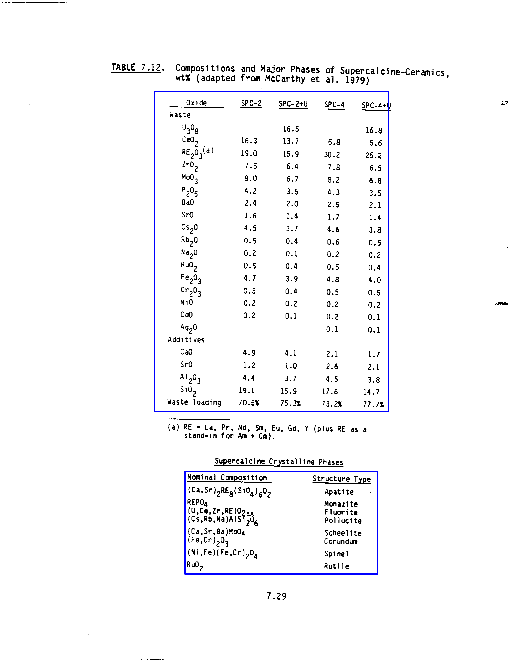

In [6]:
def draw_img_with_box(df_index, scale_percent=20):
    path_to_img = os.path.join('/content/table-detection-dataset/images', df_train.loc[df_index, 'filename'])
    img = cv2.imread(path_to_img)
    boxes =  df_train.loc[df_index, 'bbox']
    for box in boxes:
        cv2.rectangle(img, 
            (int(box[0]), int(box[1])), 
            (int(box[2]), int(box[3])), 
            (255, 0, 0), 5)
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)   
    img = cv2.resize(img, dim)
    cv2_imshow(img)

draw_img_with_box(100)

Создадим экземпляр класса torch.utils.data.Dataset. В конструктор класса передадим получившуюся таблицу и путь до папки с изображениями. Переопределим методы \_\_len\_\_ и \_\_getitem\_\_. На выходе класс будет возвращать по индексу изображение в формате torch.tensor и словарь target, в котором будет информация о искомом объекте: координаты рамки и класс. 

In [7]:
class MyDataset(Dataset):
  
    def __init__(self, dataframe, img_path):
        
        self.df = dataframe
        self.img_path = img_path

    def __len__(self):
        return self.df.shape[0]
  
    def __getitem__(self, index):
        img_name = self.df.loc[index,'filename']
        boxes = torch.Tensor(self.df.loc[index, 'bbox']).to(torch.float)
        labels = torch.Tensor(self.df.loc[index, 'class']).to(torch.int64)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        img = cv2.imread(os.path.join(self.img_path, img_name))/255.
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        return img, target

In [19]:
torch.from_numpy(cv2.imread('/content/table-detection-dataset/images/0101_003.png')/255).to(torch.float).dtype

torch.float32

Далее напишем функцию, которая будет создавать модель. Исходная модель расчитана на детекцию 91 класса. Нам нужно детектировать только один объект, поэтому необходимо заменить box_predictor. Меняем количество выходов на 2, потому что нулевым классом должен быть фон.

In [ ]:
def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

Также создадим вспомогательную функцию, которая будет применяться к бачам при итерации по torch.utils.data.DataLoader. Она поможет избежать ошибок c размерностями внутри бачей.

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

Теперь, когда все подоготовительные этапы завершены, мы можем приступать к основной части.  
В начале определим устройство, на котором будем обучать модель. Создадим саму модель, выберем оптимизатор и регулятор скорости обучения, который каждую эпоху будет уменьшать коэффициент скорости обучения. Функции потерь уже заданы внутри модели, поэтому нам не нужно их прописывать вручную.  
Обернем наши данные в torch.utils.data.DataLoader, установим размер бача в три изображения. Изображения из тренировочной выборки будем перемешивать перед подачей в модель.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=2, pretrained=False).to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_dataset = MyDataset(df_train, '/content/table-detection-dataset/images')
val_dataset = MyDataset(df_val, '/content/table-detection-dataset/images')

train_data_loader = DataLoader(
    train_dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=3,
    shuffle=False,
    collate_fn=collate_fn
)

Напишем функции для тренировки и валидации модели. Единственным отличием между ними будет отсутствие расчета градиента при валидации.  
Внутри функций мы переводим все данные внутри бача на устройтсво, на котором будут производится расчеты. Затем подаем полученные тензоры в модель и получаем словарь со значениями функций потерь. После этого посчитаем их сумму и для удобства запишем ее в переменную *running_loss* для отслеживания прогресса обучения. В конце каждой эпохи будем выводить среднее значение функций потерь.

In [ ]:
def train(train_dataloader):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tИтерация #{i} loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

Начинаем обучение.  
Создадим два списка, куда будем сохранять значения функций потерь после каждой эпохи на тренировке и валидации

In [ ]:
train_losses = []
val_losses = []
try:
    for epoch in range(20):
        start = time.time()
        train_loss = train(train_data_loader)
        val_loss = val(val_data_loader)
        scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
except KeyboardInterrupt:
    print('Прервано пользователем')

Построим график истории обучения модели


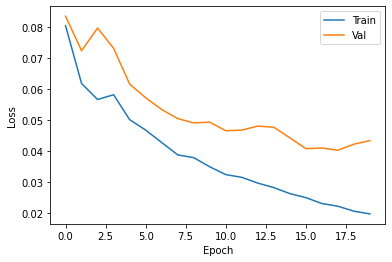

In [ ]:
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

Посмотрим, на сколько хорошо обучилась модель. Применим алгоритм non-maximum suppression, который реализован в библиотеке torchvision. Он объединяет похожие рамки на основе их взаимного пересечения.

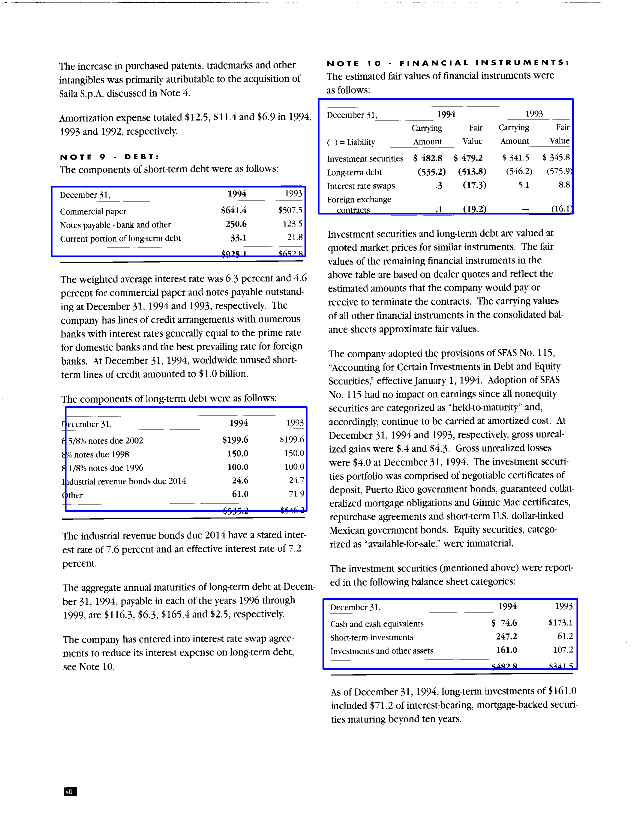

In [ ]:
def draw_predict(df_index, iou_threshold=0.1, threshold=0.8, scale_percent=25):
    model.eval()
    img = cv2.imread(os.path.join('/content/table-detection-dataset/images', df_val.loc[df_index, 'filename']))
    img_ = img / 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold:
            cv2.rectangle(img, 
                    (int(box[0]), int(box[1])), 
                    (int(box[2]), int(box[3])), 
                    (255, 0, 0), 5)
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)   
    img = cv2.resize(img, dim)
    cv2_imshow(img)
draw_predict(63, 0.1)

Сохраним веса модели

In [ ]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

Для последующего доступа к модели необходимо выполнить следующие команды:

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# load the model and the trained weights
model = create_model(2).to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn.pth'))

Теперь у нас есть обученная модель, которая может находить таблицы на сканах. Конечно, результат не всегда будет соответствовать ожиданию. Для улучшения результата можно обучить модель на более большом объеме данных. Также можно вообще поменять модель или воспользоваться уже [готовым решением](https://github.com/DevashishPrasad/CascadeTabNet).